In [709]:
import pandas as pd
from pandas_profiling import ProfileReport
from datetime import datetime

In [710]:
df= pd.read_excel(r'D:\Dev-Projects\Touch-work\noc\Ahmad masri test 2020-07-11-14-58.xlsx')
# df= pd.read_excel(r'C:\Users\Zaher Masri\Downloads\Ahmad masri test 2020-07-11-14-58.xlsx')


# rename the columns for easier access
df.columns= ['id', 'age', 'nationality', 'type',
       'days_hired', 'days_unemployed',
       'complaint_no', 'date_left', 'status',
       'termination_mode', 'date_joined',
       'interviews_no',
       'interviews_succ_no',
       'hired_no', 'canceled_no',
       'replaced_no',
       'date_hired']

# Data Cleanup

#### We have to clean the data to make any sense of it and create new meaningful variables

In [711]:
# calculate initial hold since it is not availalbe in the data
df['init_unemployed']= (pd.to_datetime(df['date_hired'], errors='coerce') - pd.to_datetime(df['date_joined'], errors='coerce')).dt.days

# negative days are probably data entry errors. Let us set it to zero
df['init_unemployed']= df.init_unemployed.apply(lambda x: 0 if x<0 else x)
df['date_joined']= pd.to_datetime(df['date_joined'], errors='coerce')
df['month_joined']= df.date_joined.apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").month if not pd.isna(x) else 0)
df['age_group']= df.age.apply(lambda x: 1 if x<24 else 2 if x<30 else 3)
df['complaint_category']=df.complaint_no.apply(lambda x: 1 if x<5 else 2 if x < 10 else 3 if x< 15 else 4)

df['interview_succ_rate']= df['interviews_succ_no']/df.interviews_no

df['interview_fail_no']= df.interviews_no- df.interviews_succ_no

df= df[~(df.status=='LANDED_IN_DUBAI')] # drop it as there is no useful data ('also small sample')

# First explore the data with little correlation to customer satisfaction


In [712]:
# Explore the authenticity of the data

print(f'ratio of walkin to total maids: {df.groupby("type").size()[1]/ df.shape[0]}') 
# ratio of walkin to total in this dataset is 30% 

# if days_hired is zero, this means either it is a problem or incorrect data

# If we define 30 days or less employment as a loss or unfruitful contract 
display(df[df.apply(lambda x: x.termination_mode=='QUIT' and x.days_hired<30, axis=1)].groupby('type').size().reset_index().rename(columns={0:'count'}))
display(df[df.apply(lambda x: x.termination_mode=='FIRED' and x.days_hired<30, axis=1)].groupby('type').size().reset_index().rename(columns={0:'count'}))

# Walkin are much more likely to quit with less than 30 days of hiring
# While it seems that more maids are fired from Freedom operator, 
# the fact stands that FREEDOM_OPERATOR data we have constitute 70% of our data 
# (we are not sure how this is an accurate representation of the company. 
# However it was mentioned that they started accepting WALKIN maids recently)

ratio of walkin to total maids: 0.2978303747534517


,type,count
0,FREEDOM_OPERATOR,73
1,WALKIN,120


,type,count
0,FREEDOM_OPERATOR,92
1,WALKIN,41


type              age_group
FREEDOM_OPERATOR  1             1
                  2            24
                  3            35
WALKIN            2            24
                  3            13
dtype: int64

type
FREEDOM_OPERATOR    AxesSubplot(0.125,0.125;0.775x0.755)
WALKIN              AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

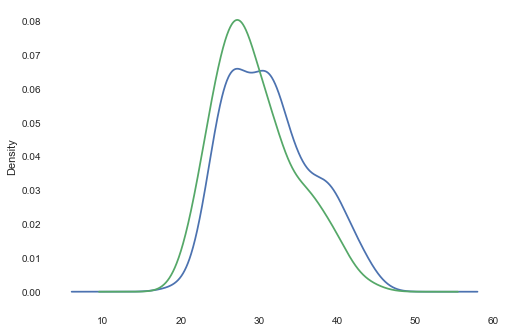

In [713]:
display(df[df.apply(lambda x: x.termination_mode=='FIRED' and x.days_hired<10, axis=1)].groupby(['type', 'age_group']).size())
display(df[df.termination_mode=='FIRED'].groupby('type').age.plot.kde())
# display(df.age.plot.kde())
# As we see here, there is very little correlation to age
# However, as we can see from below we can have the following observations:
# * In green, the walkin maids have higher firing rate at lower age, while in blue, 
# the OPERATOR maids seem to have lower firing rate at lower age
# * In general: refering to the table, it seems the both maids types are less lkely 
# to be (quickly) fired (<10 days) with younger age

type              age_group
FREEDOM_OPERATOR  1             1
                  2            24
                  3            35
WALKIN            2            24
                  3            13
dtype: int64

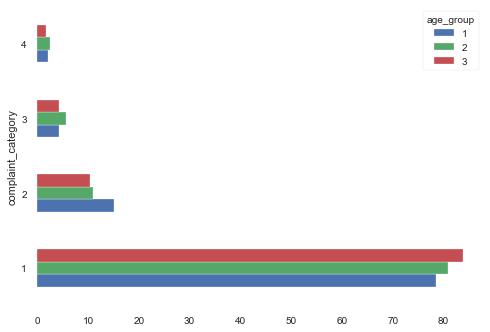

In [714]:
display(df[df.apply(lambda x: x.termination_mode=='FIRED' and x.days_hired<10, axis=1)].groupby(['type', 'age_group']).size())

grouped_data = df.groupby(['age_group', 'complaint_category']).size()\
                .groupby(level=0).apply(lambda x:  100*x / x.sum())

grouped_data.unstack(0).plot.barh()

# As we can see, there is generally less complaints for the younger maid 
# (this can be due to several reasons including the cutomer being more patient 
# with the younger inexperienced nanny, or the nanny/maid being more attentive to the customer's needs)

In [715]:
# Fill Missing Null Values

df['termination_mode']= df.apply(lambda x: 'misc' \
            if pd.isna(x.termination_mode) and x.status in ['UNREACHABLE_AFTER_EXIT', 'VISA_UNSUCCESSFUL',\
       'REJECTED','IN_EXIT', 'NO_SHOW'] \
            else 'not_terminated' \
            if pd.isna(x.termination_mode) and x.status in ['PENDING_FOR_DISCIPLINE','SICK_WITHOUT_CLIENT','AVAILABLE', 'WITH_CLIENT'] \
            else x.termination_mode, axis= 1)

display(df.groupby('termination_mode').size())

termination_mode
CONVERTED_TO_MAIDSAE       9
FIRED                    333
QUIT                     288
misc                    1263
not_terminated           642
dtype: int64

In [716]:
# Let us engineer Termination_mode, 
# FIRED is definately a bad sign. 
# QUIT can be a normal or bad sign depending on how much time days_hired have been spent


df[df.apply(lambda x: \
            x.termination_mode=='QUIT' and x.days_hired <10, axis=1)]\
            .groupby('type').size().reset_index().rename(columns={0:'count'})
# Walkin maids generally  feel less obligation to commit 


,type,count
0,FREEDOM_OPERATOR,53
1,WALKIN,115


In [717]:
# We can drop records where status is in 'EMPLOYEMENT_TERMINATED', 'IN_EXIT', 'REJECTED', \
#                                         'UNREACHABLE_AFTER_EXIT', 'VISA_UNSUCCESSFUL'
# These mostly took processing and followup manhours from the company and we will reflect on it before proceding
# These values has no or little influence on customer satisfaction

check= lambda x: (x.status in ['EMPLOYEMENT_TERMINATED', 'IN_EXIT', 'REJECTED', \
                                         'UNREACHABLE_AFTER_EXIT', 'VISA_UNSUCCESSFUL', 'NO_SHOW']) \
                 and x.days_hired ==0 

# If days_hired = 0 this means the termination has no relation to customer satisfaction

df_terminated = df[df.apply(check, axis= 1)].copy()
df=df[~df.apply(check, axis= 1)] 
tbl_size= df_terminated.groupby('type').size()
print(f"The dominant type for terminated maid with zero working days is {tbl_size.index[0]} which is {tbl_size[0]/df_terminated.shape[0]}") 
# the vast majority are via an operator. However, since the original data was also, 70/30 we cannot make any meaningful observations


The dominant type for terminated maid with zero working days is FREEDOM_OPERATOR which is 0.7069081153588196


In [718]:
# Now let's assume that when a date is missing, the total

# if we want to be more accurate we will only fill the ones hired
# once with the days_unemployed, and the rest according to the hiring times
df['init_unemployed']= df.apply(lambda x: x.days_unemployed if pd.isna(x.init_unemployed) else x.init_unemployed, axis= 1)

In [783]:
temp= df[['nationality', 'type', 'init_unemployed']].copy()


temp['type']= temp.type.apply(lambda x: 1 if x=='WALKIN' else 2)

categorize = {"nationality":     {'Kenyan': 1, 'Ethiopian': 2, 'Cameroonian': 3, 'Ivorian': 4, 'Ugandan': 5,
       'Nigerian': 6, 'Ghanaian': 7, 'Togolese': 8, 'Sierra Leonean': 9, 'Zimbabwean': 10, 'Gambian': 11, 'Congolese': 12, 'Liberian': 13}}
temp.replace(categorize, inplace=True)
temp.reset_index(drop=True, inplace=True)

temp.corr()
# The below confirms what we have discovered that the data is very unbalanced and there is a large correlation between the type and nationality


,nationality,type,init_unemployed
nationality,1.000000,-0.506975,0.070021
type,-0.506975,1.000000,0.055798
init_unemployed,0.070021,0.055798,1.000000


In [720]:
# Here we will do something alittle different: 
# we will correlate each country with respect to the other countries to see the effect of that specific nationality

for i in range(13):
    temp['temp_nationality']=temp.nationality.apply(lambda x: 1 if x==i+1 else 2)
    temp.reset_index(drop=True, inplace=True)
    display(f'{i+1}:', temp[temp.nationality==i+1].shape[0], temp[temp.nationality==i+1][['init_unemployed', 'type']].corr())
    display(f'{i+1}:', temp[temp.nationality==i+1].shape[0], temp[['init_unemployed','temp_nationality']].corr())

# The most correlation was for 3 nationalities: Kenyan, Ugandan and Ghanaian. 
# However, the correlation is relatively low and we need to look deeper 
# There is a reasonable correlation of Ugandan with correlation score of 0.215 and type of maid relating to initial unemployment

D:\Development-Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


'1:'

287

,init_unemployed,type
init_unemployed,1.00000,0.06325
type,0.06325,1.00000


'1:'

287

,init_unemployed,temp_nationality
init_unemployed,1.00000,0.07579
temp_nationality,0.07579,1.00000


D:\Development-Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


'2:'

241

,init_unemployed,type
init_unemployed,1.00000,0.04721
type,0.04721,1.00000


'2:'

241

,init_unemployed,temp_nationality
init_unemployed,1.000000,-0.007404
temp_nationality,-0.007404,1.000000


D:\Development-Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


'3:'

131

,init_unemployed,type
init_unemployed,1.000000,0.151761
type,0.151761,1.000000


'3:'

131

,init_unemployed,temp_nationality
init_unemployed,1.000000,0.006478
temp_nationality,0.006478,1.000000


D:\Development-Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


'4:'

3

,init_unemployed,type
init_unemployed,1.0,0.5
type,0.5,1.0


'4:'

3

,init_unemployed,temp_nationality
init_unemployed,1.000000,0.008523
temp_nationality,0.008523,1.000000


D:\Development-Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


'5:'

120

,init_unemployed,type
init_unemployed,1.000000,0.215287
type,0.215287,1.000000


'5:'

120

,init_unemployed,temp_nationality
init_unemployed,1.000000,-0.058269
temp_nationality,-0.058269,1.000000


D:\Development-Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


'6:'

177

,init_unemployed,type
init_unemployed,1.000000,0.019625
type,0.019625,1.000000


'6:'

177

,init_unemployed,temp_nationality
init_unemployed,1.000000,-0.008443
temp_nationality,-0.008443,1.000000


D:\Development-Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


'7:'

69

,init_unemployed,type
init_unemployed,1.000000,0.049774
type,0.049774,1.000000


'7:'

69

,init_unemployed,temp_nationality
init_unemployed,1.000000,-0.046418
temp_nationality,-0.046418,1.000000


D:\Development-Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


'8:'

1

,init_unemployed,type
init_unemployed,NaN,NaN
type,NaN,NaN


'8:'

1

,init_unemployed,temp_nationality
init_unemployed,1.000000,0.009966
temp_nationality,0.009966,1.000000


D:\Development-Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


'9:'

5

,init_unemployed,type
init_unemployed,1.00,-0.25
type,-0.25,1.00


'9:'

5

,init_unemployed,temp_nationality
init_unemployed,1.000000,0.010109
temp_nationality,0.010109,1.000000


D:\Development-Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


'10:'

3

,init_unemployed,type
init_unemployed,1.0,NaN
type,NaN,NaN


'10:'

3

,init_unemployed,temp_nationality
init_unemployed,1.000000,-0.026496
temp_nationality,-0.026496,1.000000


D:\Development-Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


'11:'

3

,init_unemployed,type
init_unemployed,NaN,NaN
type,NaN,NaN


'11:'

3

,init_unemployed,temp_nationality
init_unemployed,1.000000,0.017278
temp_nationality,0.017278,1.000000


D:\Development-Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


'12:'

3

,init_unemployed,type
init_unemployed,1.0,NaN
type,NaN,NaN


'12:'

3

,init_unemployed,temp_nationality
init_unemployed,1.00000,-0.01599
temp_nationality,-0.01599,1.00000


D:\Development-Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


'13:'

1

,init_unemployed,type
init_unemployed,NaN,NaN
type,NaN,NaN


'13:'

1

,init_unemployed,temp_nationality
init_unemployed,1.000000,0.009966
temp_nationality,0.009966,1.000000


D:\Development-Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


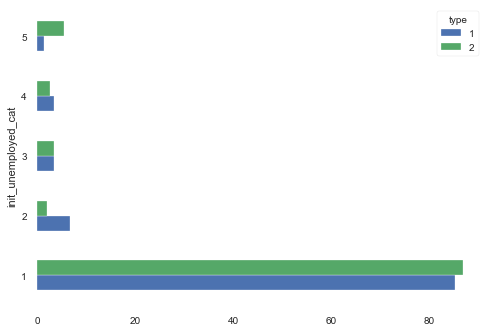

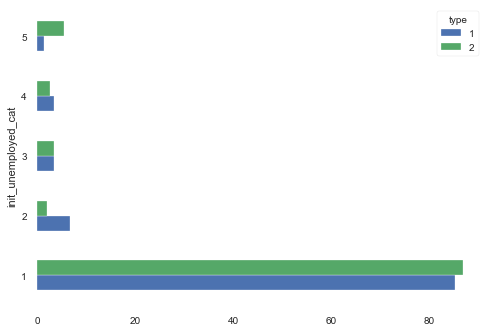

In [721]:
# temp[temp.nationality==3 ][temp.type==1].groupby('init_unemployed').size()
# temp[temp.nationality==5 ][temp.type==2].groupby('init_unemployed').size()

temp['init_unemployed_cat']= temp['init_unemployed'].apply(lambda x: 1 if x<5 else 2 if x<10 else 3 if x<20 else 4 if x < 30 else 5)

grouped_temp = temp.groupby(['type', 'init_unemployed_cat']).size()\
                .groupby(level=0).apply(lambda x:  100*x / x.sum())

grouped_temp.unstack(0).plot.barh()
grouped_temp.unstack(0).plot.barh()

# for i in range(13):
#     grouped_temp = temp[temp.nationality==i+1].groupby(['type', 'init_unemployed_cat']).size()\
#                     .groupby(level=0).apply(lambda x:  100*x / x.sum())
#     grouped_temp.unstack(0).plot.barh()

# What the below can show us, is that mainly type 2 maids (operator) usually take more time to be initially hired 
# (this can maybe justified due to less experience and word of mouth from the locals)

# The data has to be understood right. 

### First: we notice that nationality is strongly correlated to the type like below: 

#### for example, almost all Nigerian nationality are WALKIN
#### another example would be Ethiopian, and Kenyan where the vast Majority are FREEDOM_OPERATOR

### Thus correlating to a type wouldn't be accurate without the correlation being underlined as a nationality correlation (has to be double checked)
### Therefore, we should look deep into our data to make any assumption

# Let us do a comprehensive correlation and see what we can find

In [723]:
temp= df[['nationality', 'type', 'days_hired', 'days_unemployed',
       'complaint_no','hired_no','canceled_no', 'replaced_no', 'init_unemployed',
       'month_joined', 'age_group', 'complaint_category','interview_fail_no']].copy()

temp['type']= temp.type.apply(lambda x: 1 if x=='WALKIN' else 2)

categorize = {"nationality":     {'Kenyan': 1, 'Ethiopian': 2, 'Cameroonian': 3, 'Ivorian': 4, 'Ugandan': 5,
       'Nigerian': 6, 'Ghanaian': 7, 'Togolese': 8, 'Sierra Leonean': 9, 'Zimbabwean': 10, 'Gambian': 11, 'Congolese': 12, 'Liberian': 13}}
temp.replace(categorize, inplace=True)
temp.reset_index(drop=True, inplace=True)


profile = ProfileReport(temp, explorative=True)
profile.to_widgets()

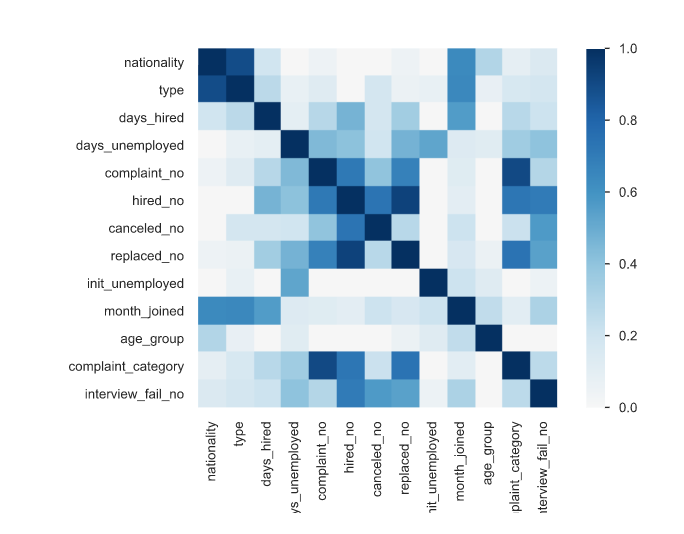

## The comprehensive correlation We have constructed in the diagram shows us several correlations which we have have already explored, and some new ones we still need to explore. (We use Phi_K correlation which is an improvement on the Pearson's correlation hyposisis) 

- ### The obvious correlation is between the type and nationality which we have explored earlier 
- ### We need to thouroly explore the correlation between the month joined and type/nationality
- ### There is a slight correlation between type and days_hired which can be a small reflection of customer satisfaction
- ### there is a trivial correlation between complaint_category and replaced_no/canceled_no

In [524]:
temp1=df_terminated.groupby('nationality').size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False)
temp1['percent']= temp1['count'].transform(lambda x: x/sum(x))

temp2=df.groupby('nationality').size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False)
temp2['percent']= temp2['count'].transform(lambda x: x/sum(x))

temp3 = pd.merge(temp1, temp2, on='nationality', how='inner')

temp3['percent_rejections']= temp3.apply(lambda x: x.count_y/x.count_x, axis= 1)
display(temp3.head(5))
# Out of the top 5 countries, Ethiopian and Nigerian are among the top dopped out rate before an interview


# We already established that this behavior has no correlation to the type of the maid



# We can divide this dataset in to termination with days_unemployed>0, and days_unemployed=0

df_terminated[~df_terminated.apply(lambda x: x.days_hired==0 and x.days_unemployed==0 , axis=1)]

,nationality,count_x,percent_x,count_y,percent_y,percent_rejections
0,Ethiopian,393,0.263581,241,0.229743,0.613232
1,Kenyan,380,0.254863,288,0.274547,0.757895
2,Ugandan,321,0.215292,121,0.115348,0.376947
3,Cameroonian,169,0.113347,133,0.126787,0.786982
4,Nigerian,126,0.084507,177,0.168732,1.404762


,id,age,nationality,type,days_hired,days_unemployed,complaint_no,date_left,status,termination_mode,...,interviews_no,interviews_succ_no,hired_no,canceled_no,replaced_no,date_hired,init_unemployed,month_joined,age_group,complaint_category
13,13561,35.0,Kenyan,FREEDOM_OPERATOR,0,4,0,2019-02-28 09:31:37,EMPLOYEMENT_TERMINATED,QUIT,...,0,0,0,0,0,NaN,NaN,0,3,1
55,13692,30.0,Kenyan,FREEDOM_OPERATOR,0,23,0,2019-03-17 13:00:21,EMPLOYEMENT_TERMINATED,FIRED,...,0,0,0,0,0,NaN,NaN,3,3,1
74,13746,42.0,Kenyan,FREEDOM_OPERATOR,0,40,0,2019-04-07 00:00:00,EMPLOYEMENT_TERMINATED,FIRED,...,1,0,0,0,0,NaN,NaN,3,3,1
78,13775,39.0,Kenyan,FREEDOM_OPERATOR,0,10,0,2019-02-24 12:29:56,EMPLOYEMENT_TERMINATED,QUIT,...,1,0,0,0,0,NaN,NaN,0,3,1
80,13777,36.0,Kenyan,FREEDOM_OPERATOR,0,29,0,2019-04-02 11:13:00,EMPLOYEMENT_TERMINATED,FIRED,...,1,0,0,0,0,NaN,NaN,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1724,19973,31.0,Ugandan,WALKIN,0,2,0,2020-01-08 00:00:00,EMPLOYEMENT_TERMINATED,QUIT,...,0,0,0,0,0,NaN,NaN,0,3,1
1779,20129,28.0,Ethiopian,FREEDOM_OPERATOR,0,16,0,2020-03-13 10:00:02,EMPLOYEMENT_TERMINATED,QUIT,...,15,0,0,0,0,NaN,NaN,3,2,1
2113,21068,37.0,Nigerian,WALKIN,0,1,0,2020-04-09 00:00:00,VISA_UNSUCCESSFUL,QUIT,...,0,0,0,0,0,NaN,NaN,0,3,1
2179,21161,28.0,Nigerian,WALKIN,0,26,0,2020-04-19 00:00:00,EMPLOYEMENT_TERMINATED,FIRED,...,0,0,0,0,0,NaN,NaN,4,2,1


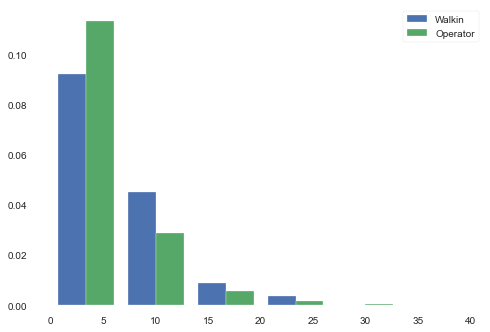

In [746]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

test= temp[['complaint_no', 'type']].copy()
x = test[test.type==1].complaint_no
y = test[test.type==2].complaint_no
bins = np.linspace(0, 40, 7)

plt.hist([x, y], bins, label=['Walkin', 'Operator'], density=True) # normalize results
plt.legend(loc='upper right')
plt.show()

# In general we can see that Operator Maids has less (high number of complaints per observation) cases compared to the walkin maids


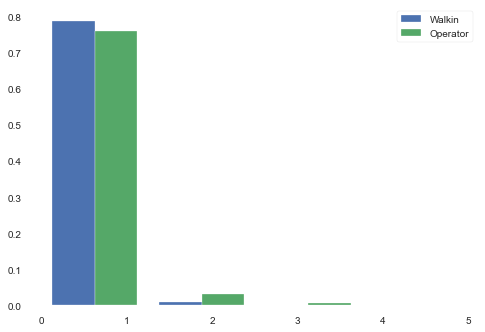

In [747]:
plt.style.use('seaborn-deep')

test= temp[['canceled_no', 'type']].copy()
x = test[test.type==1].canceled_no
y = test[test.type==2].canceled_no
bins = np.linspace(0, 5, 5)

plt.hist([x, y], bins, label=['Walkin', 'Operator'], density=True) # normalize results
plt.legend(loc='upper right')
plt.show()

# Cancellation rate is very similar between the two types 

In [750]:
temp.columns

Index(['nationality', 'type', 'days_hired', 'days_unemployed', 'complaint_no',
       'hired_no', 'canceled_no', 'replaced_no', 'init_unemployed',
       'month_joined', 'age_group', 'complaint_category', 'interview_fail_no'],
      dtype='object')

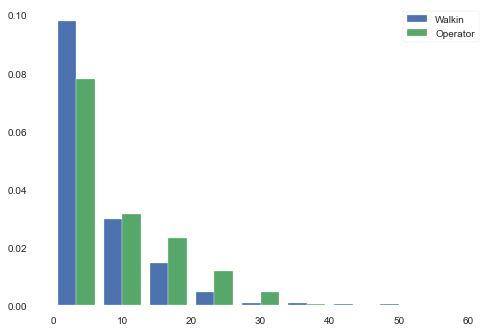

In [762]:
plt.style.use('seaborn-deep')

test= temp[['interview_fail_no', 'type']].copy()
x = test[test.type==1].interview_fail_no
y = test[test.type==2].interview_fail_no
bins = np.linspace(0, 60, 10)

plt.hist([x, y], bins, label=['Walkin', 'Operator'], density=True) # normalize results
plt.legend(loc='upper right')
plt.show()

# We can correlate below a higher rate of failed interviews to the Operator, but let's investigate below 


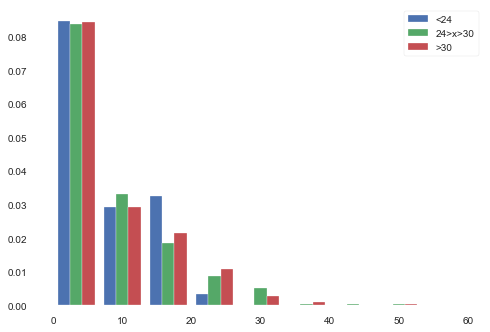

In [765]:
plt.style.use('seaborn-deep')

test= temp[['interview_fail_no', 'age_group']].copy()
x = test[test.age_group==1].interview_fail_no
y = test[test.age_group==2].interview_fail_no
z = test[test.age_group==3].interview_fail_no
bins = np.linspace(0, 60, 10)

plt.hist([x, y, z], bins, label=['<24', '24>x>30', '>30'], density=True) # normalize results
plt.legend(loc='upper right')
plt.show()
# There is little correlation to the failed interview number due to age_group

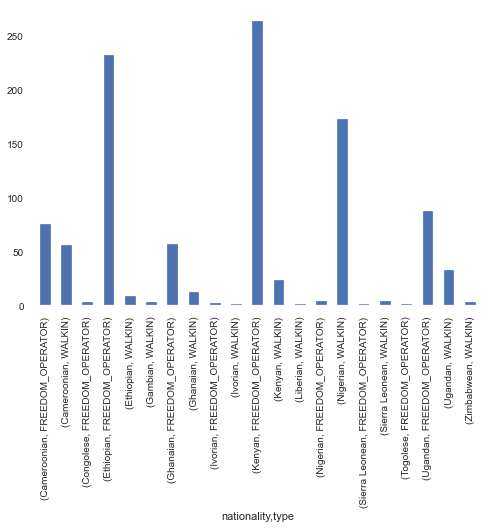

In [590]:
# display(test.groupby(['nationality', 'type']).size())

s=test.groupby(['nationality', 'type']).size()#.plot(style= 'o', rot= 90)
# display (s)

# plt.style.use('seaborn-deep')

# x = test[test.type=='WALKIN'].nationality
# y = test[test.type=='FREEDOM_OPERATOR'].nationality

s.plot.bar(rot=90) # normalize results

In [540]:
# df['month_joined']= df.apply(lambda x: datetime.strptime(x.date_joined, "%Y-%m-%d %H:%M:%S").month, axis=1)
df.drop(columns= ['date_left', 'date_joined', 'date_hired'])
# let us drop date_left as for the remaining entries, even if fired or quit is on the record, there is only one valid leave date

,id,age,nationality,type,days_hired,days_unemployed,complaint_no,status,termination_mode,interviews_no,interviews_succ_no,hired_no,canceled_no,replaced_no,init_unemployed,month_joined,age_group,complaint_category
1,13515,29.0,Ethiopian,FREEDOM_OPERATOR,283,56,11,WITH_CLIENT,NaN,15,5,5,0,4,0.0,2,2,3
2,13516,26.0,Ethiopian,FREEDOM_OPERATOR,491,8,1,WITH_CLIENT,NaN,1,1,1,0,0,0.0,3,2,1
6,13528,40.0,Kenyan,FREEDOM_OPERATOR,69,90,0,EMPLOYEMENT_TERMINATED,FIRED,7,1,1,1,0,18.0,3,3,1
8,13530,38.0,Kenyan,FREEDOM_OPERATOR,5,41,1,EMPLOYEMENT_TERMINATED,FIRED,13,1,1,0,1,0.0,2,3,1
10,13558,28.0,Kenyan,FREEDOM_OPERATOR,462,6,6,WITH_CLIENT,NaN,7,3,3,1,1,0.0,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528,21774,25.0,Ugandan,WALKIN,1,4,0,WITH_CLIENT,NaN,0,0,1,0,0,NaN,0,2,1
2530,21782,26.0,Kenyan,WALKIN,4,1,0,WITH_CLIENT,NaN,1,1,2,0,0,0.0,7,2,1
2532,21786,27.0,Ugandan,WALKIN,9,1,1,WITH_CLIENT,NaN,1,1,1,0,0,0.0,7,2,1
2533,21798,43.0,Liberian,WALKIN,0,0,0,AVAILABLE,NaN,0,0,0,0,0,NaN,0,3,1


In [541]:
df[~pd.isna(df.termination_mode)].shape

(401, 21)

In [542]:
df_terminated.groupby('termination_mode').size()
# df= df[~df.apply(lambda x: x.days_hired==0, axis=1)] # drop the rest as hire number >=1 hire days should be much more


termination_mode
CONVERTED_TO_MAIDSAE      5
FIRED                    72
QUIT                    152
dtype: int64

### First let us talk about the correlation between the age group and the complaint number. 
### Although the distribution of complaints is similar, we can observe:
- ### less variance for the compalints towards the lower total complaints levels per observation for the younger maids
- ### More outliers towards the very high number of complaints with higher age

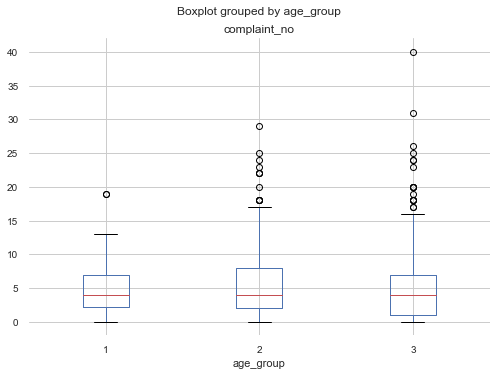

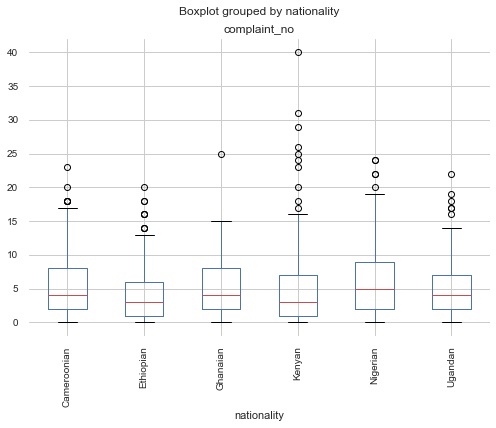

In [779]:
df[~(df.days_hired==0)].groupby('nationality').size()
nat= df[df.nationality.apply(lambda x: x in ['Cameroonian', 'Ethiopian', 'Ghanaian', 'Kenyan', 'Nigerian', 'Ugandan'] )] # get rid of nationality with few observations < 50
display(temp.boxplot(column='complaint_no', by='age_group'))
display(nat.boxplot(column='complaint_no', by='nationality', rot=90))

# From the below, Ethiopian and Ugandan Nationalities seem to have the lowest complaint concentration.
# Kenyen generally has low varience and low complaints. However it has the largest ammount of outliers that need to be checked

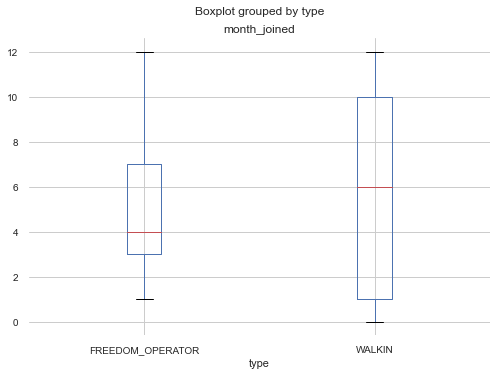

In [775]:
# From the below, we notice that most of the operator flights come between March and July, 
# while for walkin they are spread through the year 
# There should be an explanation why. 

display(df.boxplot(column='month_joined', by='type')) 

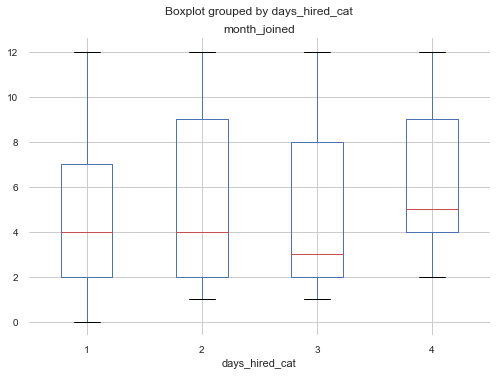

In [782]:
df['days_hired_cat']= df.days_hired.apply(lambda x: 1 if x<30 else 2 if x< 100 else 3 if x < 200 else 4)

display(df.boxplot(column='month_joined', by='days_hired_cat')) 

# It seem there is a weird correlation to the join date of the spring/summer months to longer hiring duration

<h1><center>Conclusion and Thoughts</center></h1>

- ### The main correlation to the type which wasn't related in a way or another to the nationality or other factors is the early quitting for walkins relating to the operator maids
- ### There was some correlation between type of maids and customer satisfaction as in general we can see that Operator Maids has less (high number of complaints per observation) cases compared to the walkin maids
- ### complaints were generally lower for the younger maids wich are mostly operator maids so this could mess up any assumption of the type of maids we already considered

## Thoughts
- ### This was a very nice excersize where we explored a wealth of data. However, to decide if we must procede with a certain type of maid, we need more data to be able to correlate customer satisfaction.

### For example:
- ### Customer type: family, corporation, elderly
- ### Need more data about some nationalities which had negligible sample size
- ### We need to explore the outliers 
- ### We need to get more information about the reason of quitting/firing
- ### We need to calculate days for initial unimployed expenses, combine with the expenses of operator (zero for walkin and 4000 UAD for operator), and find a measure for customer satisfaction relating to higher number of hiring days and continued business with the company